# Creating a training dataset for training Generative Adversarial Networks for emulating GW Flow Simulations

In [4]:
# import 
import numpy as np
import os 
# import sys
# sys.path.insert(0, '../')
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi
from geone.deesse_core.deesse import MPDS_MISSING_VALUE # constant for missing value

# import flopy stuff
import flopy
import flopy.utils.binaryfile as bf

# import the custom functions
import func.flowSimforReals as fwReal
import func.flowSimforTrue as fwTrue



flopy is installed in /home/local/UNINE.CH/dagasany/anaconda3/envs/flowSimul/lib/python3.7/site-packages/flopy


In [5]:
# Read the TI (Img Class)
ti_filename = 'data/ti_strebelle_K.gslib'
ti = img.readImageGslib(ti_filename, missing_value=MPDS_MISSING_VALUE)

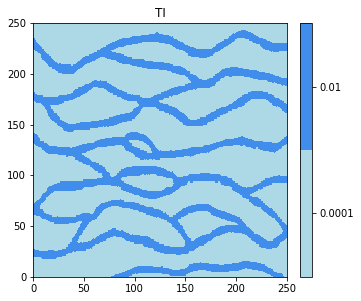

In [6]:
col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')

In [7]:
# Set input for deesse
# --------------------
# DeeSse input parameters to create the true K field
deesse_input_true = dsi.DeesseInput(
    nx=128,ny=128,nz=1,nv=1,varname='facies',
    nTI=1,TI=ti,
    searchNeighborhoodParameters=dsi.SearchNeighborhoodParameters(rx=40.,ry=40.),
    nneighboringNode=30,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=1234,
    nrealization=20)

In [8]:
# DeeSse input parameters to create the realisations for training the ML
deesse_input_realisations = dsi.DeesseInput(
    nx=128,ny=128,nz=1,nv=1,varname='facies',
    nTI=1,TI=ti,
    searchNeighborhoodParameters=dsi.SearchNeighborhoodParameters(rx=40.,ry=40.),
    nneighboringNode=30,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=10000)


In [9]:
# Do deesse simulations to generate the true field and the realisations of it
# --------------------
doSimul=False

if doSimul:
    # create the candidate true K field realisations to choose as the ground truth
    trueKList = dsi.deesseRun(deesse_input_true)
    trueK     = img.gatherImages(trueKList)
    # Do deesse simulation to generate the realisations using the TI
    simKList  = dsi.deesseRun(deesse_input_realisations)
    simK      = img.gatherImages(simKList)
    # Write the simulations and true field in GSLIB files
    img.writeImageGslib(trueK,filename= ("results/GSLIB/128*128/trueK.gslib"))
    img.writeImageGslib(simK,filename= ("results/GSLIB/128*128/simK.gslib"))
else:
    # Import the fields
    trueK_filename = 'results/GSLIB/trueK.gslib'
    simK_filename  = 'results/GSLIB/simK.gslib'
    trueK = img.readImageGslib(trueK_filename, missing_value=MPDS_MISSING_VALUE)
    simK  = img.readImageGslib(simK_filename, missing_value=MPDS_MISSING_VALUE)


##  Set up the flow simulations using MODFLOW


In [11]:

# Alternative 
model_ws_trueK =os.path.join("modflow", "modflowFiles")
model_ws_simK  =os.path.join("modflow", "modflowFiles")

modelname_trueK = 'true_flow'
modelname_simK  = 'sim_flow'

exe_name = os.path.join(os.getcwd(), 'modflow/exeMF/mf2005')

mf_trueK = flopy.modflow.Modflow(modelname=modelname_trueK, exe_name=exe_name,
                                model_ws=model_ws_trueK)
mf_simK = flopy.modflow.Modflow(modelname=modelname_simK, exe_name=exe_name,
                                 model_ws=model_ws_simK)

trueKindex = 4
# --------------------
# Model domain and grid definition
Lx   =  128. # Length in x direction
Ly   =  128. # Length in y direction 
ztop =  0.   # Top elevation of the layer
zbot = -50.  # Bottom elevation of the layer 
nlay =  1    # number of layers 
nrow =  128  # number of rows (number of grid nodes in y direction)
ncol =  128  # number of columns (number of grid nodes in x direction)
wcol =  64   # x index for the well to discharge or recharge
wrow =  64   # y index for the well to discharge or recharge

delr = Lx/ncol # Calculate the length of each grid ALONG the rows
delc = Ly/nrow # Calculate the length of each grid ALONG the columns
delv = (ztop - zbot) / nlay # Calculate the length of the grid along layers
botm = np.linspace(ztop, zbot, nlay + 1) # Vector for Bottom and top Elevations
wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delr)) # Well location

# Create the discretization object (grid)
dis_trueK = flopy.modflow.ModflowDis(mf_trueK, nlay, nrow, 
                                     ncol, delr=delr, delc=delc,
                                     top=ztop, botm=botm[1])
dis_simK = flopy.modflow.ModflowDis(mf_simK, nlay, nrow,
                                    ncol, delr=delr, delc=delc,
                                    top=ztop, botm=botm[1])

# Variables for the BAS (basic) package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) # Create an empty 1s array
ibound[:, :, 0]  = -1 # Constant head values at the left boundary
ibound[:, :, -1] = -1 # Constant head values at the right boundary
strt = np.ones((nlay, nrow, ncol), dtype=np.float32) # Create an empty 1s array
strt[:, :, 0]  = 1. # Boundary conditions: Head values at the left boundary
strt[:, :, -1] = 0. # Boundary conditions: Head values at the right boundary
bas_trueK = flopy.modflow.ModflowBas(mf_trueK, ibound=ibound, strt=strt)
bas_simK  = flopy.modflow.ModflowBas(mf_simK, ibound=ibound, strt=strt)

# Add LPF (Layer Property Flow) package to the MODFLOW model
lpf_trueK = flopy.modflow.ModflowLpf(mf_trueK, hk=trueK.val[trueKindex,:,:,:], vka=0., ipakcb=53)
lpf_simK  = flopy.modflow.ModflowLpf(mf_simK, hk=simK.val[trueKindex,:,:,:], vka=0., ipakcb=53)

# Add the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -0.003
wel_sp = [[0, wrow, wcol, pumping_rate]] # lay, row, col index, pumping rate
stress_period_data = {0: wel_sp} # define well stress period {period, well info dictionary}
wel_trueK = flopy.modflow.ModflowWel(mf_trueK, stress_period_data=stress_period_data)
wel_simK = flopy.modflow.ModflowWel(mf_simK, stress_period_data=stress_period_data)


# Add OC (Output Control Option) package to the MODFLOW model
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc_trueK = flopy.modflow.ModflowOc(mf_trueK, stress_period_data=spd, compact=True)
oc_simK  = flopy.modflow.ModflowOc(mf_simK, stress_period_data=spd, compact=True)

# Add PCG (Preconditioned-Conj. Gradient Solver) package to the MODFLOW model
pcg_trueK = flopy.modflow.ModflowPcg(mf_trueK) # Solver
pcg_simK = flopy.modflow.ModflowPcg(mf_simK) # Solver

# Write the MODFLOW model input files into the model directory
mf_trueK.write_input()
mf_simK.write_input()


Exception: Util2d:self.shape: (128, 128) does not match value.shape: (100, 100)

##  Set up the flow simulations using MODFLOW


In [ ]:
# Run the MODFLOW model and check if the operation is successful
if doSimul:
    success_trueK, buff_trueK = mf_trueK.run_model()
    success_simK,  buff_simK = mf_simK.run_model()


